In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from collections import Counter
from datasets import Dataset, DatasetDict, load_from_disk
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

from sklearn.metrics import accuracy_score, f1_score, classification_report

2025-12-11 01:59:00.880763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765418340.902729     183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765418340.909498     183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Load Data**

In [ ]:
import shutil

shutil.copytree('/kaggle/input/dataset/data/dataset_splits', '/kaggle/working/dataset_splits')

In [ ]:
path = '/kaggle/working/dataset_splits'

datasets = DatasetDict({
    "train": load_from_disk(f"{path}/train"),
    "validation": load_from_disk(f"{path}/validation"),
    "test": load_from_disk(f"{path}/test")
})
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'label'],
        num_rows: 167611
    })
    validation: Dataset({
        features: ['text', 'category', 'label'],
        num_rows: 20951
    })
    test: Dataset({
        features: ['text', 'category', 'label'],
        num_rows: 20952
    })
})

In [5]:
for i in range(5):
    print(f"Text: {datasets['train']['text'][i]}")
    print(f"Category: {datasets['train']['category'][i]}")
    print(f"Label: {datasets['train']['label'][i]}")
    print("\n")

Text: JetBlue Cancellations Ruined My Vacation Before It Started: Here's What Would Have Fixed It I apologize in advance if this comes off as an angry rant, that's the coffee talking. Then again, I wouldn't be up at 4 a.m. going strong on four cups were it not for JetBlue.
Category: TRAVEL
Label: 21


Text: American Parents Are Not Powerless When It Comes to Violence Prevention We, as parents, can play a role in preventing violence at our schools. We are not powerless. We do not have to wait on institutions that are slow-moving and hard to influence -- specifically, the federal government and national media -- to care for America's children.
Category: PARENTING
Label: 14


Text: Dog Who Ran Away Amid Shooting At Congressional Baseball Practice Is Found Daphne, a black and white pointer mix, was at a dog park adjacent to the site of the shooting when she was "scared off by the gunshots."
Category: MISCELLANEOUS
Label: 13


Text: Where Did My Hammock Time Go? My hammock is sacred to me: 

# **Category - Label mapping**

In [6]:
# Extract category-label mapping from the dataset
df = datasets['train'].to_pandas()[['category', 'label']].drop_duplicates()

category2label = dict(zip(df['category'], df['label']))
label2category = dict(zip(df['label'], df['category']))

print(category2label)
print(label2category)

{'TRAVEL': 21, 'PARENTING': 14, 'MISCELLANEOUS': 13, 'WELLNESS': 24, 'GROUPS VOICES': 9, 'BUSINESS & FINANCES': 1, 'POLITICS': 15, 'WEDDINGS': 22, 'ENTERTAINMENT': 6, 'FOOD & DRINK': 8, 'IMPACT': 11, 'WOMEN': 25, 'WORLD NEWS': 26, 'DIVORCE': 4, 'SPORTS': 18, 'ENVIRONMENT': 7, 'ARTS & CULTURE': 0, 'STYLE & BEAUTY': 19, 'RELIGION': 16, 'COMEDY': 2, 'TECH': 20, 'HOME & LIVING': 10, 'WEIRD NEWS': 23, 'SCIENCE': 17, 'CRIME': 3, 'MEDIA': 12, 'EDUCATION': 5}
{21: 'TRAVEL', 14: 'PARENTING', 13: 'MISCELLANEOUS', 24: 'WELLNESS', 9: 'GROUPS VOICES', 1: 'BUSINESS & FINANCES', 15: 'POLITICS', 22: 'WEDDINGS', 6: 'ENTERTAINMENT', 8: 'FOOD & DRINK', 11: 'IMPACT', 25: 'WOMEN', 26: 'WORLD NEWS', 4: 'DIVORCE', 18: 'SPORTS', 7: 'ENVIRONMENT', 0: 'ARTS & CULTURE', 19: 'STYLE & BEAUTY', 16: 'RELIGION', 2: 'COMEDY', 20: 'TECH', 10: 'HOME & LIVING', 23: 'WEIRD NEWS', 17: 'SCIENCE', 3: 'CRIME', 12: 'MEDIA', 5: 'EDUCATION'}


# **Fine-tuning**

In [24]:
model_name = 'bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(category2label),
    id2label=label2category,
    label2id=category2label
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Tokenize**

**Analyze the dataset**

Token Length Statistics:
Mean: 39.81
Median: 38.00
Min: 2
Max: 353

Percentiles:
90th percentile: 63.0
95th percentile: 71.0
99th percentile: 85.0


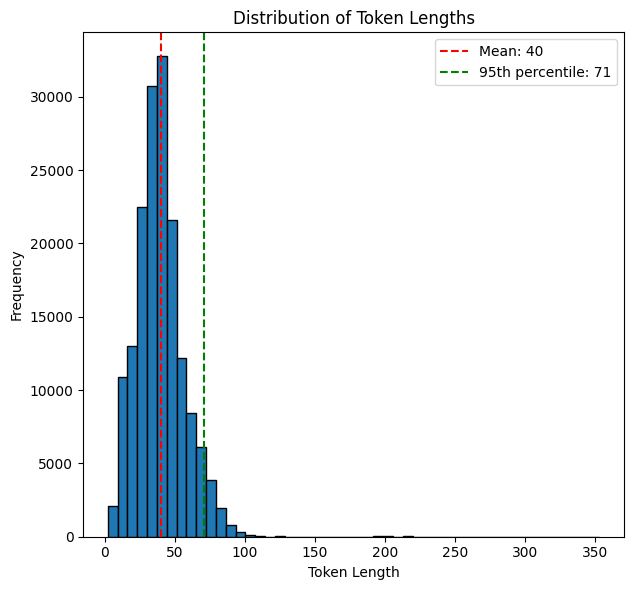

In [9]:
texts = datasets['train']['text']
# Tokenize all texts and get lengths
token_lengths = []
for text in texts:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
# Statistic
print(f"Token Length Statistics:")
print(f"Mean: {token_lengths.mean():.2f}")
print(f"Median: {np.median(token_lengths):.2f}")
print(f"Min: {token_lengths.min()}")
print(f"Max: {token_lengths.max()}")
print(f"\nPercentiles:")
print(f"90th percentile: {np.percentile(token_lengths, 90)}")
print(f"95th percentile: {np.percentile(token_lengths, 95)}")
print(f"99th percentile: {np.percentile(token_lengths, 99)}")

# Visualize distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.axvline(token_lengths.mean(), color='r', linestyle='--', label=f'Mean: {token_lengths.mean():.0f}')
plt.axvline(np.percentile(token_lengths, 95), color='g', linestyle='--', label=f'95th percentile: {np.percentile(token_lengths, 95):.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_ds = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/167611 [00:00<?, ? examples/s]

Map:   0%|          | 0/20951 [00:00<?, ? examples/s]

Map:   0%|          | 0/20952 [00:00<?, ? examples/s]

## **Processing imbalance**

In [12]:
from sklearn.utils.class_weight import compute_class_weight

labels = datasets['train']['label']

# Get unique class labels
unique_classes = np.unique(labels)

# Calculate the frequency of each class
class_frequencies = [np.sum(labels == c) for c in unique_classes]

total_samples = len(labels)

# Calculate the logarithmic weights for each class
log_class_weights = {c: np.log(total_samples / freq) for c, freq in zip(unique_classes, class_frequencies)}
log_class_weights_tensor = torch.tensor(list(log_class_weights.values()), dtype=torch.float).to(device)


In [13]:
print("Logarithmic class Weights:")
for class_idx, weight in log_class_weights.items():
    # Get the actual category name
    category_name = label2category[class_idx]
    frequency = class_frequencies[class_idx]

    print(f"Class {class_idx:2d} | {category_name:20s} | Weight: {weight:.4f} | Samples: {frequency}")

Logarithmic class Weights:
Class  0 | ARTS & CULTURE       | Weight: 3.9781 | Samples: 3138
Class  1 | BUSINESS & FINANCES  | Weight: 3.2974 | Samples: 6198
Class  2 | COMEDY               | Weight: 3.6584 | Samples: 4320
Class  3 | CRIME                | Weight: 4.0743 | Samples: 2850
Class  4 | DIVORCE              | Weight: 4.1133 | Samples: 2741
Class  5 | EDUCATION            | Weight: 4.5758 | Samples: 1726
Class  6 | ENTERTAINMENT        | Weight: 2.4905 | Samples: 13889
Class  7 | ENVIRONMENT          | Weight: 3.9424 | Samples: 3252
Class  8 | FOOD & DRINK         | Weight: 3.2123 | Samples: 6749
Class  9 | GROUPS VOICES        | Weight: 2.8549 | Samples: 9648
Class 10 | HOME & LIVING        | Weight: 3.8815 | Samples: 3456
Class 11 | IMPACT               | Weight: 4.0967 | Samples: 2787
Class 12 | MEDIA                | Weight: 4.2651 | Samples: 2355
Class 13 | MISCELLANEOUS        | Weight: 4.3156 | Samples: 2239
Class 14 | PARENTING            | Weight: 2.7996 | Samples: 10

## **Training**

In [14]:
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits

    loss_fct = nn.CrossEntropyLoss(weight=log_class_weights_tensor)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [15]:
# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "macro_precision": precision,
        "macro_recall": recall,
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/bert-news-category",        # Directory for model checkpoints
    eval_strategy="epoch",                                  # Evaluate at the end of every epoch
    save_strategy="epoch",                                  # Save model after each epoch
    num_train_epochs=4,                                     # Number of epochs
    learning_rate=2e-5,                                     # Learning rate
    per_device_train_batch_size=32,                         # Batch size per device
    per_device_eval_batch_size=16,                          # Eval batch size
    weight_decay=0.01,                                      # Weight decay for regularization
    warmup_ratio=0.1,                                       # Warmup ratio
    push_to_hub = True,                                     # Push to hugging face
    hub_model_id = "VTKK/bert-news-category-classification",
    logging_strategy="steps",
    logging_steps=500,                                      # Log every 500 steps
    load_best_model_at_end=True,                            # Load best model at the end of training
    metric_for_best_model="macro_f1",                       # Select model base on macro-F1
    greater_is_better=True,
    save_safetensors=True,
    seed=42,
    report_to= "none"
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
import os

def get_latest_checkpoint(output_dir):
    # Identify folders matching checkpoint-N
    checkpoints = [
        os.path.join(output_dir, d)
        for d in os.listdir(output_dir)
        if os.path.isdir(os.path.join(output_dir, d)) and re.match(r"checkpoint-\d+", d)
    ]

    if not checkpoints:
        return None  # No checkpoint found

    # Sort numerically by checkpoint number
    checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
    return checkpoints[-1]  # Latest checkpoint folder


latest_ckpt = get_latest_checkpoint(output_dir)
print("Latest checkpoint:", latest_ckpt)

if latest_ckpt:
    print(f"Resuming training from: {latest_ckpt}")
    trainer.train(resume_from_checkpoint=latest_ckpt)
else:
    print("No checkpoints found. Starting new training.")

**Push model to hugging face**

In [ ]:
# login huggingface hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub(commit_message="Upload fine-tuned model")

# **Evaluation**

In [ ]:
model_name = 'VTKK/bert-news-category-classification'
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_test = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/167611 [00:00<?, ? examples/s]

Map:   0%|          | 0/20951 [00:00<?, ? examples/s]

Map:   0%|          | 0/20952 [00:00<?, ? examples/s]

In [29]:
id2label = model.config.id2label
label2id = model.config.label2id
label_list = list(id2label.values())

## Evaluate on the test set

In [30]:
eval_args = TrainingArguments(
    #output_dir="./eval_results",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer = CustomTrainer(
    model=model,
    args=eval_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_183/3876284552.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [34]:
results = trainer.evaluate(eval_dataset=tokenized_test["test"])

print("="*50)
print("Evaluation Metrics:")
print("="*50)
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Evaluation Metrics:
eval_loss: 1.6882
eval_accuracy: 0.7397
eval_macro_f1: 0.6730
eval_macro_precision: 0.6760
eval_macro_recall: 0.6709
eval_runtime: 103.5524
eval_samples_per_second: 202.3320
eval_steps_per_second: 6.3250


## Entity level classification report

In [36]:
predictions, labels, _ = trainer.predict(tokenized_test["test"])
pred_ids = np.argmax(predictions, axis=1)

print(pred_ids[:10])

[15  6  6 19  6 24  6 19 22 15]


In [37]:
true_preds = [label_list[p] for p in pred_ids]
true_labels = [label_list[l] for l in labels]

print("\n Detailed Classification Report:\n")
print(classification_report(true_labels, true_preds))


 Detailed Classification Report:

                     precision    recall  f1-score   support

     ARTS & CULTURE       0.62      0.60      0.61       392
BUSINESS & FINANCES       0.67      0.67      0.67       775
             COMEDY       0.58      0.54      0.56       540
              CRIME       0.65      0.58      0.62       356
            DIVORCE       0.82      0.84      0.83       342
          EDUCATION       0.52      0.57      0.54       216
      ENTERTAINMENT       0.75      0.78      0.77      1737
        ENVIRONMENT       0.62      0.61      0.61       407
       FOOD & DRINK       0.85      0.85      0.85       844
      GROUPS VOICES       0.68      0.65      0.67      1206
      HOME & LIVING       0.79      0.82      0.81       432
             IMPACT       0.45      0.43      0.44       348
              MEDIA       0.63      0.57      0.60       294
      MISCELLANEOUS       0.43      0.41      0.42       280
          PARENTING       0.76      0.77      0.7

## Confusion matrix

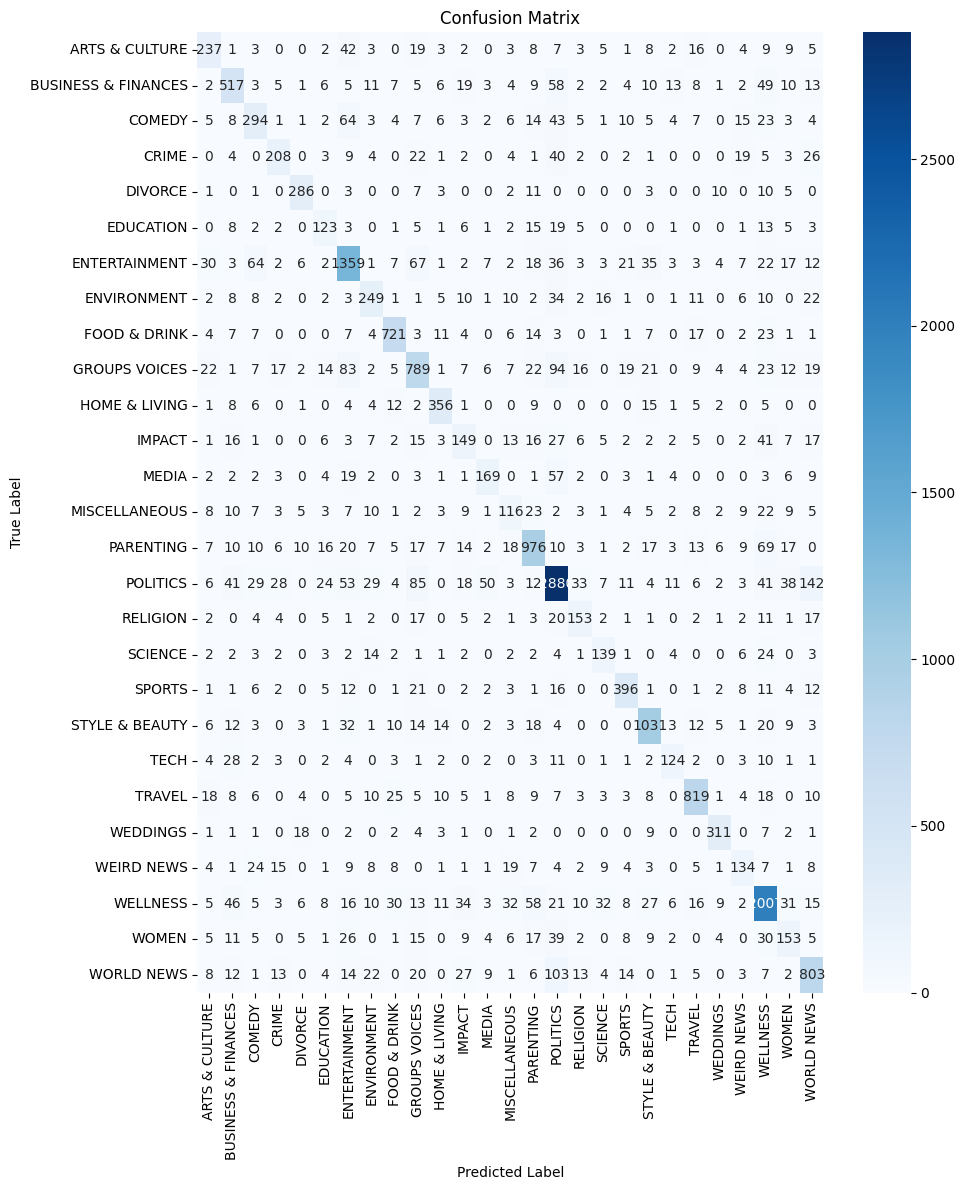

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_names = label_list
cm = confusion_matrix(true_labels, true_preds)

# Plot
plt.figure(figsize=(10, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()